# Paper Figures
1. Map of regions
2. `NPP` predictability heatmap
3. `SIE` predictability heatmap
4. "Propagation" of predictability (`SIE`, `MLD`, `SFC_IRR`, `NPP`, and maybe `SFC_CHL`, `SFC_BIOMASS`) 
5. `SIE` predicting `NPP` cross correlation
6. `SFC_IRR` predicting `NPP` cross correlation

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as stats
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean.cm as cmo

In [19]:
mpl.rcParams['figure.dpi'] = 500
%config InlineBackend.figure_formats = ['png']

# %config InlineBackend.figure_formats = ['pdf']

In [3]:
def open_metric(var, reg, metric, timescale='monthly', ens_type='', ctrl_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_'+ctrl_type+'derived/'
    
    if metric.lower() == 'clim':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+metric+'.nc'
    
    if metric.lower() == 'anom' or metric.lower() == 'mean' or (metric.lower() == 'var' and timescale.lower() == 'monthly'):
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric.lower() == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

def get_plotting_labels():
    with open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb') as handle:
        plotting_dicts = pkl.load(handle)
    
    reg_names = plotting_dicts['reg_names_A/B']
    var_abbrv_names = plotting_dicts['var_abbrv_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    month_letters = plotting_dicts['month_letters']
    var_su_names = plotting_dicts['var_su_names']
    
    return reg_names, var_abbrv_names, abbrv_month_names, month_letters, var_su_names

## Predictability Heatmap 

In [4]:
def ppp_simple_heatmap(
    var, vmin=0, threshold=0.183, hatch='//', cmap=cmo.matter, figsize=(12,8), titlefontsize='large', labelfontsize='large'):

    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names_A/B']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']

    ppp = open_metric(var, 'so', 'ppp')
    regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

    fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
    
    subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

    for (ireg,reg) in zip(range(len(regions)), regions):
        ppp_matrix = np.zeros((10,12))

        for m in range(ppp['nT'].size):
            ppp_matrix[int(m/12),m%12] = ppp[reg][m]

        ppp_matrix = ppp_matrix.T

        im = ax[int(ireg/3),ireg%3].pcolormesh(ppp_matrix, vmin=vmin, vmax=1.0, cmap=cmap, shading='auto')

        ax[int(ireg/3),ireg%3].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', fontsize=titlefontsize, loc='left')

        ax[int(ireg/3),ireg%3].set_yticks(np.arange(ppp_matrix.shape[0]) + 0.5)
        ax[int(ireg/3),ireg%3].set_yticklabels(abbrv_month_names, fontsize=labelfontsize)

        ax[int(ireg/3),ireg%3].set_xticks(np.arange(ppp_matrix.shape[1]) + 0.5)
        ax[int(ireg/3),ireg%3].set_xticklabels(np.arange(1,11,1), fontsize=labelfontsize)
        ax[int(ireg/3),ireg%3].set_aspect('auto')

        if int(ireg/3) == 1:
            ax[int(ireg/3),ireg%3].set_xlabel('Year', fontsize=labelfontsize)

        if hatch:
            masked = np.ma.masked_array(ppp_matrix, mask=np.where(ppp_matrix > threshold, 0, 1))
            masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)

    plt.suptitle('PM predictability of '+var_su_names[var], x=0.424, fontweight='bold', fontsize=titlefontsize+4)
    fig.tight_layout()

    cb = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.06)
    cb.ax.fill_between([-0.1,1.1], [1.0,1.0], [threshold,threshold], hatch=hatch, alpha=0)
    cb.ax.plot([-0.1,1.1], [threshold,threshold], color='k', linewidth=1)
    cb.ax.set_ylabel('PPP', fontsize=labelfontsize)

    cb.ax.arrow(x=-0.5, y=0+0.01, dx=0, dy=0.183-0.01, clip_on=False, length_includes_head=True, 
                width=0.1, head_length=0.02, head_width=0.4,
                facecolor='grey', edgecolor='grey')
    cb.ax.arrow(x=-0.5, y=0.183-0.01, dx=0, dy=-0.183+0.01, clip_on=False, length_includes_head=True, 
                width=0.1, head_length=0.02, head_width=0.4,
                facecolor='grey', edgecolor='grey')
    cb.ax.text(x=-1, y=0.183 + (1-0.183)/2, s='Predictable', clip_on=False, ha='center', va='center', rotation='vertical',
              color='grey', fontsize=labelfontsize-1, fontweight='bold')
    
    cb.ax.arrow(x=-0.5, y=1-0.01, dx=0, dy=0.183-1+0.01, clip_on=False, length_includes_head=True, 
                width=0.1, head_length=0.02, head_width=0.4,
                facecolor='grey', edgecolor='grey')
    cb.ax.arrow(x=-0.5, y=0.183+0.01, dx=0, dy=1-0.183-0.01, clip_on=False, length_includes_head=True, 
                width=0.1, head_length=0.02, head_width=0.4,
                facecolor='grey', edgecolor='grey')
    cb.ax.text(x=-1, y=0.183/2, s='Not predictable', clip_on=False, ha='center', va='center', rotation='vertical',
              color='grey', fontsize=labelfontsize-1, fontweight='bold')

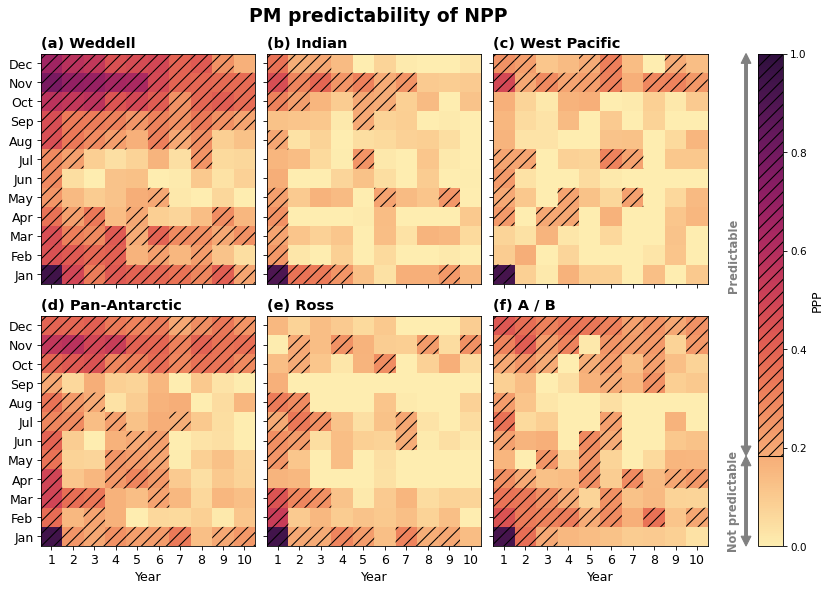

In [5]:
ppp_simple_heatmap('npp', threshold=0.183, labelfontsize=12, titlefontsize=14)

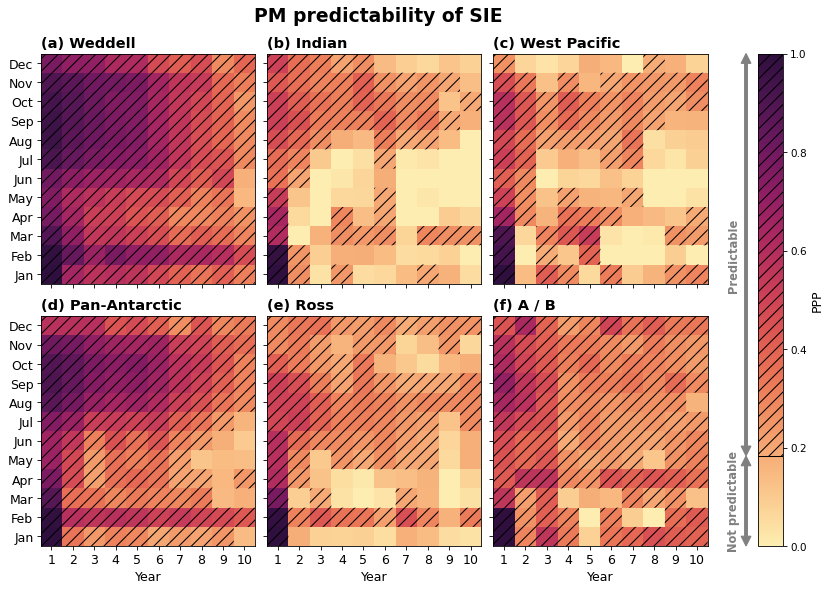

In [6]:
ppp_simple_heatmap('sie', threshold=0.183, labelfontsize=12, titlefontsize=14)

## Predictability Timeseries

In [7]:
def ppp_timeseries(
    variables=['SIE','MLD','SFC_IRR','NPP'], threshold=0.183, endmonth=14, ylim=(-0.2,1),
    figsize=(14,8), titlefontsize='large', labelfontsize='large'):

    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names_A/B']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    var_abbrv_names = plotting_dicts['var_abbrv_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    var_colors = plotting_dicts['var_colors']
    month_letters = plotting_dicts['month_letters']
    
    regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

    fig,ax = plt.subplots(2, 3, figsize=figsize)
    subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

    for var in variables:
        ppp = open_metric(var, 'so', 'ppp')
        for (ireg,reg) in enumerate(regions):
            
            if var.lower() == 'npp':
                ax[int(ireg/3),ireg%3].plot(ppp[reg].values[:endmonth], color=var_colors[var.lower()],
                                            label=var_abbrv_names[var.lower()], linewidth=3)
            if var.lower() != 'npp':
                ax[int(ireg/3),ireg%3].plot(ppp[reg].values[:endmonth], color=var_colors[var.lower()],
                                            label=var_su_names[var.lower()], alpha=0.5)
            
            ax[int(ireg/3),ireg%3].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', fontsize=titlefontsize, loc='left')
            
            if var == variables[-1]:
                ax[int(ireg/3),ireg%3].axhline(threshold, 0, endmonth, color='grey', ls='--', alpha=0.5,
                                               label='Threshold for\npredictability\n(PPP=0.183)')
            if var != variables[-1]:
                ax[int(ireg/3),ireg%3].axhline(threshold, 0, endmonth, color='grey', ls='--', alpha=0.5)

            ax[int(ireg/3),ireg%3].axvline(10, ylim[0], ylim[1], color='grey', ls=':', alpha=0.5)    

            ax[int(ireg/3),ireg%3].set_ylim(ylim[0],ylim[1])
            ax[int(ireg/3),ireg%3].set_xlim(0,endmonth-1)
            ax[int(ireg/3),ireg%3].set_xticks(np.arange(0,endmonth,2))
            ax[int(ireg/3),ireg%3].set_xticklabels(np.array(2*abbrv_month_names)[np.arange(0,endmonth,2)])
            ax[int(ireg/3),ireg%3].tick_params(axis='both', which='major', labelsize=labelfontsize-2)

            if int(ireg/3) == 1:
                ax[int(ireg/3),ireg%3].set_xlabel('Forecast month', fontsize=labelfontsize)
                
            if ireg%3 == 0:
                ax[int(ireg/3),ireg%3].set_ylabel('PPP', fontsize=labelfontsize)
             
            if ireg == 2:
                ax[int(ireg/3),ireg%3].legend(bbox_to_anchor=(1.02, 1.02), loc='upper left', fontsize=labelfontsize-2)
                
            if ireg == len(regions)-1:
                ax[int(ireg/3),ireg%3].arrow(x=endmonth-1+0.75, dx=0, y=ylim[0]+0.01, dy=-ylim[0]+0.183-0.01, clip_on=False, 
                                             length_includes_head=True, width=0.1, head_length=0.05, head_width=0.4, 
                                             facecolor='grey', edgecolor='grey')
                ax[int(ireg/3),ireg%3].arrow(x=endmonth-1+0.75, dx=0, y=0.183-0.01, dy=ylim[0]-0.182+0.01, clip_on=False, 
                                             length_includes_head=True, width=0.1, head_length=0.05, head_width=0.4, 
                                             facecolor='grey', edgecolor='grey')
                ax[int(ireg/3),ireg%3].text(x=endmonth+0.5, y=0.183 + (ylim[1]-0.183)/2, s='Predictable', clip_on=False, 
                                            ha='center', va='center', rotation='vertical', color='grey',
                                            fontsize=labelfontsize-2, fontweight='normal')

                ax[int(ireg/3),ireg%3].arrow(x=endmonth-1+0.75, dx=0, y=ylim[1]-0.01, dy=0.183-ylim[1]+0.01, clip_on=False, 
                                             length_includes_head=True, width=0.1, head_length=0.05, head_width=0.4, 
                                             facecolor='grey', edgecolor='grey')
                ax[int(ireg/3),ireg%3].arrow(x=endmonth-1+0.75, dx=0, y=0.183+0.01, dy=ylim[1]-0.183-0.01, clip_on=False, 
                                             length_includes_head=True, width=0.1, head_length=0.05, head_width=0.4, 
                                             facecolor='grey', edgecolor='grey')
                ax[int(ireg/3),ireg%3].text(x=endmonth+0.75, y=ylim[0] - (ylim[0]-0.183)/2, s='Not\npredictable', clip_on=False, 
                                            ha='center', va='center', rotation='vertical', color='grey',
                                            fontsize=labelfontsize-2, fontweight='normal')
            
        
    fig.suptitle('Time series of first year PM predictability', x=0.47, ha='center', fontweight='bold', fontsize=titlefontsize+2)
    fig.tight_layout()

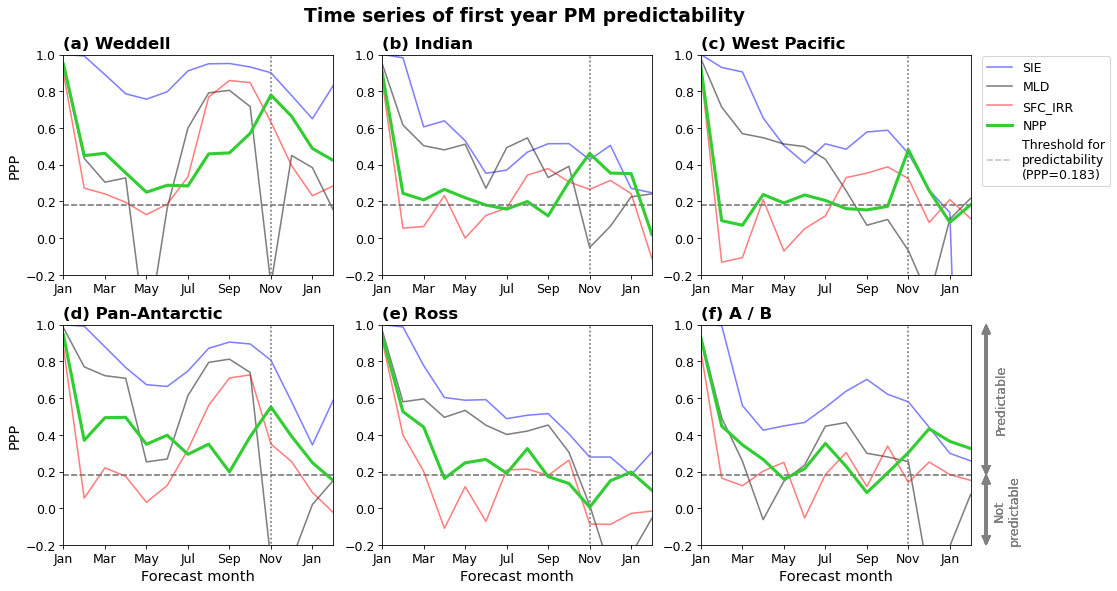

In [8]:
ppp_timeseries(variables=['SIE','MLD','SFC_IRR','NPP'], labelfontsize=14, titlefontsize=16, figsize=(15,8))

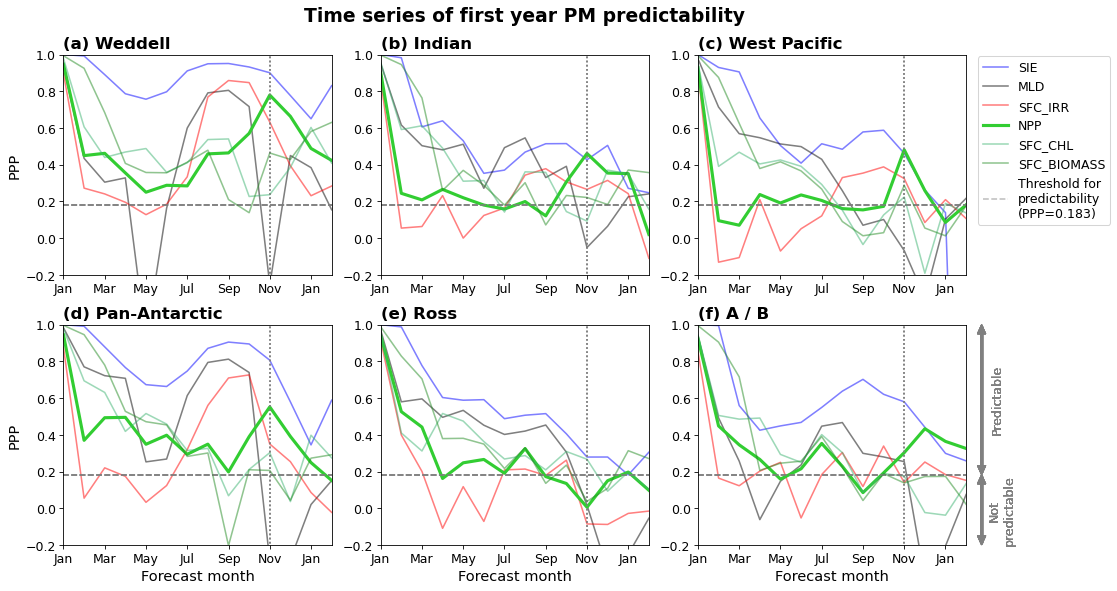

In [9]:
ppp_timeseries(variables=['SIE','MLD','SFC_IRR','NPP', 'SFC_CHL', 'SFC_BIOMASS'], labelfontsize=14, titlefontsize=16, figsize=(15,8))

## "Propagation" of Predictability

In [10]:
def ppp_var_heatmap(
    variables, reg, num_months=24, vmin=-0.2, threshold=0.183, hatch='\\', yaxis_steps=2, cmap=cmo.matter, figsize=(8,7), titlefontsize=16,
    labelfontsize=14):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names_A/B']
    var_su_names = plotting_dicts['var_su_names']
#     var_su_names = {'npp': 'NPP',
#                      'mld': 'MLD',
#                      'sie': 'SIE',
#                      'sst': 'SST',
#                      'sss': 'SSS',
#                      'cn_inv': 'SIC',
#                      'pco2surf': 'Surface pCO$_2$',
#                      'siv': 'SIV',
#                      'sfc_fed': 'Iron',
#                      'sfc_irr': 'Irradiance',
#                      'sfc_biomass': 'Biomass',
#                      'sfc_chl': 'Chl $a$'}

#     regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
    regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

    variable_names = []
    
    if reg.lower() == 'all':
        
        fig,ax = plt.subplots(2, 3, sharex=True, figsize=figsize)
        
        subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

        for (ireg,reg) in zip(range(len(regions)), regions):
            ppp_matrix = np.zeros((len(variables),num_months))

            for (i,var) in zip(range(len(variables)), variables):
                ppp = open_metric(var, 'so', 'ppp')
                ppp_matrix[i] = ppp[reg][0:num_months]
                if ireg == 0:
                    variable_names.append(var_su_names[var])

            ppp_matrix = ppp_matrix.T

            im = ax[int(ireg/3),ireg%3].pcolormesh(ppp_matrix, vmin=vmin, vmax=1.0, cmap=cmap, shading='auto')

            ax[int(ireg/3),ireg%3].set_yticks(np.arange(0,ppp_matrix.shape[0],yaxis_steps) + 0.5)            
            ax[int(ireg/3),ireg%3].set_yticklabels(np.arange(0,ppp_matrix.shape[0],yaxis_steps), fontsize=labelfontsize)
            
            if ireg%3 == 0:
                ax[int(ireg/3),ireg%3].set_ylabel('Forecast month', fontsize=labelfontsize)

            ax[int(ireg/3),ireg%3].set_xticks(np.arange(ppp_matrix.shape[1]) + 0.5)
            ax[int(ireg/3),ireg%3].set_xticklabels(variable_names, fontsize=labelfontsize)
            plt.setp(ax[int(ireg/3),ireg%3].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=labelfontsize)
            
            ax[int(ireg/3),ireg%3].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', loc='left', fontsize=titlefontsize)

    
            if hatch:
                masked = np.ma.masked_array(ppp_matrix, mask=np.where(ppp_matrix > threshold, 0, 1))
                masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)
#                 masked = np.ma.masked_array(ppp_matrix, mask=np.where((ppp_matrix > 0.183) & (ppp_matrix < threshold), 0, 1))
#                 masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch='//', alpha=0)

#         fig.suptitle('1$^{st}$ Year PM Predictability', x=0.424, fontweight='bold', fontsize=titlefontsize+4)
        fig.suptitle('PM predictability of spring bloom drivers', x=0.424, fontweight='bold', fontsize=titlefontsize+4)
        fig.tight_layout()

        cb = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.06)
        cb.ax.plot([-0.1,1.1], [threshold,threshold], color='k', linewidth=1)
        cb.ax.plot([-0.1,1.1], [0.183,0.183], color='k', linewidth=1)
        cb.ax.fill_between([-0.1,1.1], [1.0,1.0], [threshold,threshold], hatch=hatch, alpha=0)
        cb.set_label('PPP', fontsize=labelfontsize)
#         cb.ax.fill_between([-0.1,1.1], [1.0,1.0], [0.183,0.183], hatch='//', alpha=0)
        
        cb.ax.arrow(x=-0.5, y=0+0.01, dx=0, dy=0.183-0.01, clip_on=False, length_includes_head=True, 
                width=0.1, head_length=0.02, head_width=0.4,
                facecolor='grey', edgecolor='grey')
        cb.ax.arrow(x=-0.5, y=0.183-0.01, dx=0, dy=-0.183+0.01, clip_on=False, length_includes_head=True, 
                    width=0.1, head_length=0.02, head_width=0.4,
                    facecolor='grey', edgecolor='grey')
        cb.ax.text(x=-1, y=0.183 + (1-0.183)/2, s='Predictable', clip_on=False, ha='center', va='center', rotation='vertical',
                  color='grey', fontsize=labelfontsize-1, fontweight='bold')

        cb.ax.arrow(x=-0.5, y=1-0.01, dx=0, dy=0.183-1+0.01, clip_on=False, length_includes_head=True, 
                    width=0.1, head_length=0.02, head_width=0.4,
                    facecolor='grey', edgecolor='grey')
        cb.ax.arrow(x=-0.5, y=0.183+0.01, dx=0, dy=1-0.183-0.01, clip_on=False, length_includes_head=True, 
                    width=0.1, head_length=0.02, head_width=0.4,
                    facecolor='grey', edgecolor='grey')
        cb.ax.text(x=-1, y=0.183/2, s='Not predictable', clip_on=False, ha='center', va='center', rotation='vertical',
                  color='grey', fontsize=labelfontsize-1, fontweight='bold')

#         cb.ax.text(0.5, vmin-0.03, 'No skill', ha='center', va='center', fontsize=labelfontsize)
#         cb.ax.text(0.5, 1.0+0.03, 'Perfect skill', ha='center', va='center', fontsize=labelfontsize)

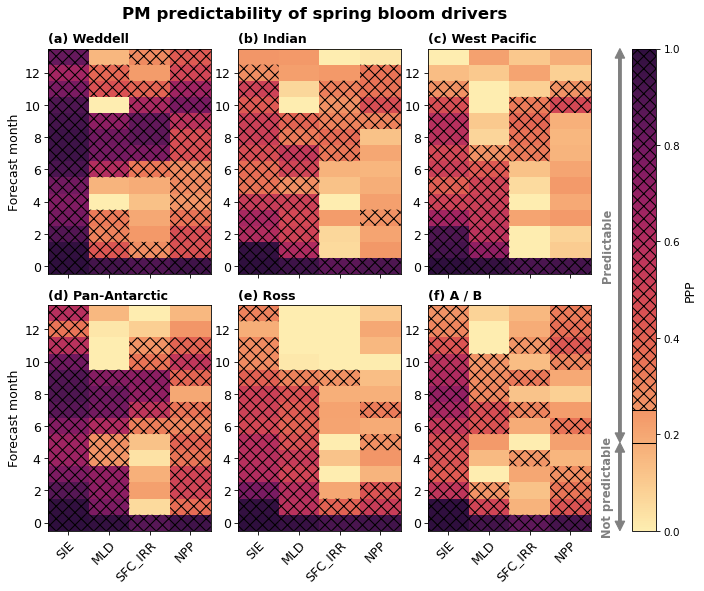

In [11]:
variables = ['sie', 'mld', 'sfc_irr', 'npp']
ppp_var_heatmap(variables, 'all', num_months=14, figsize=(10,8), vmin=0, threshold=0.25, labelfontsize=12, titlefontsize=12, hatch='xx');

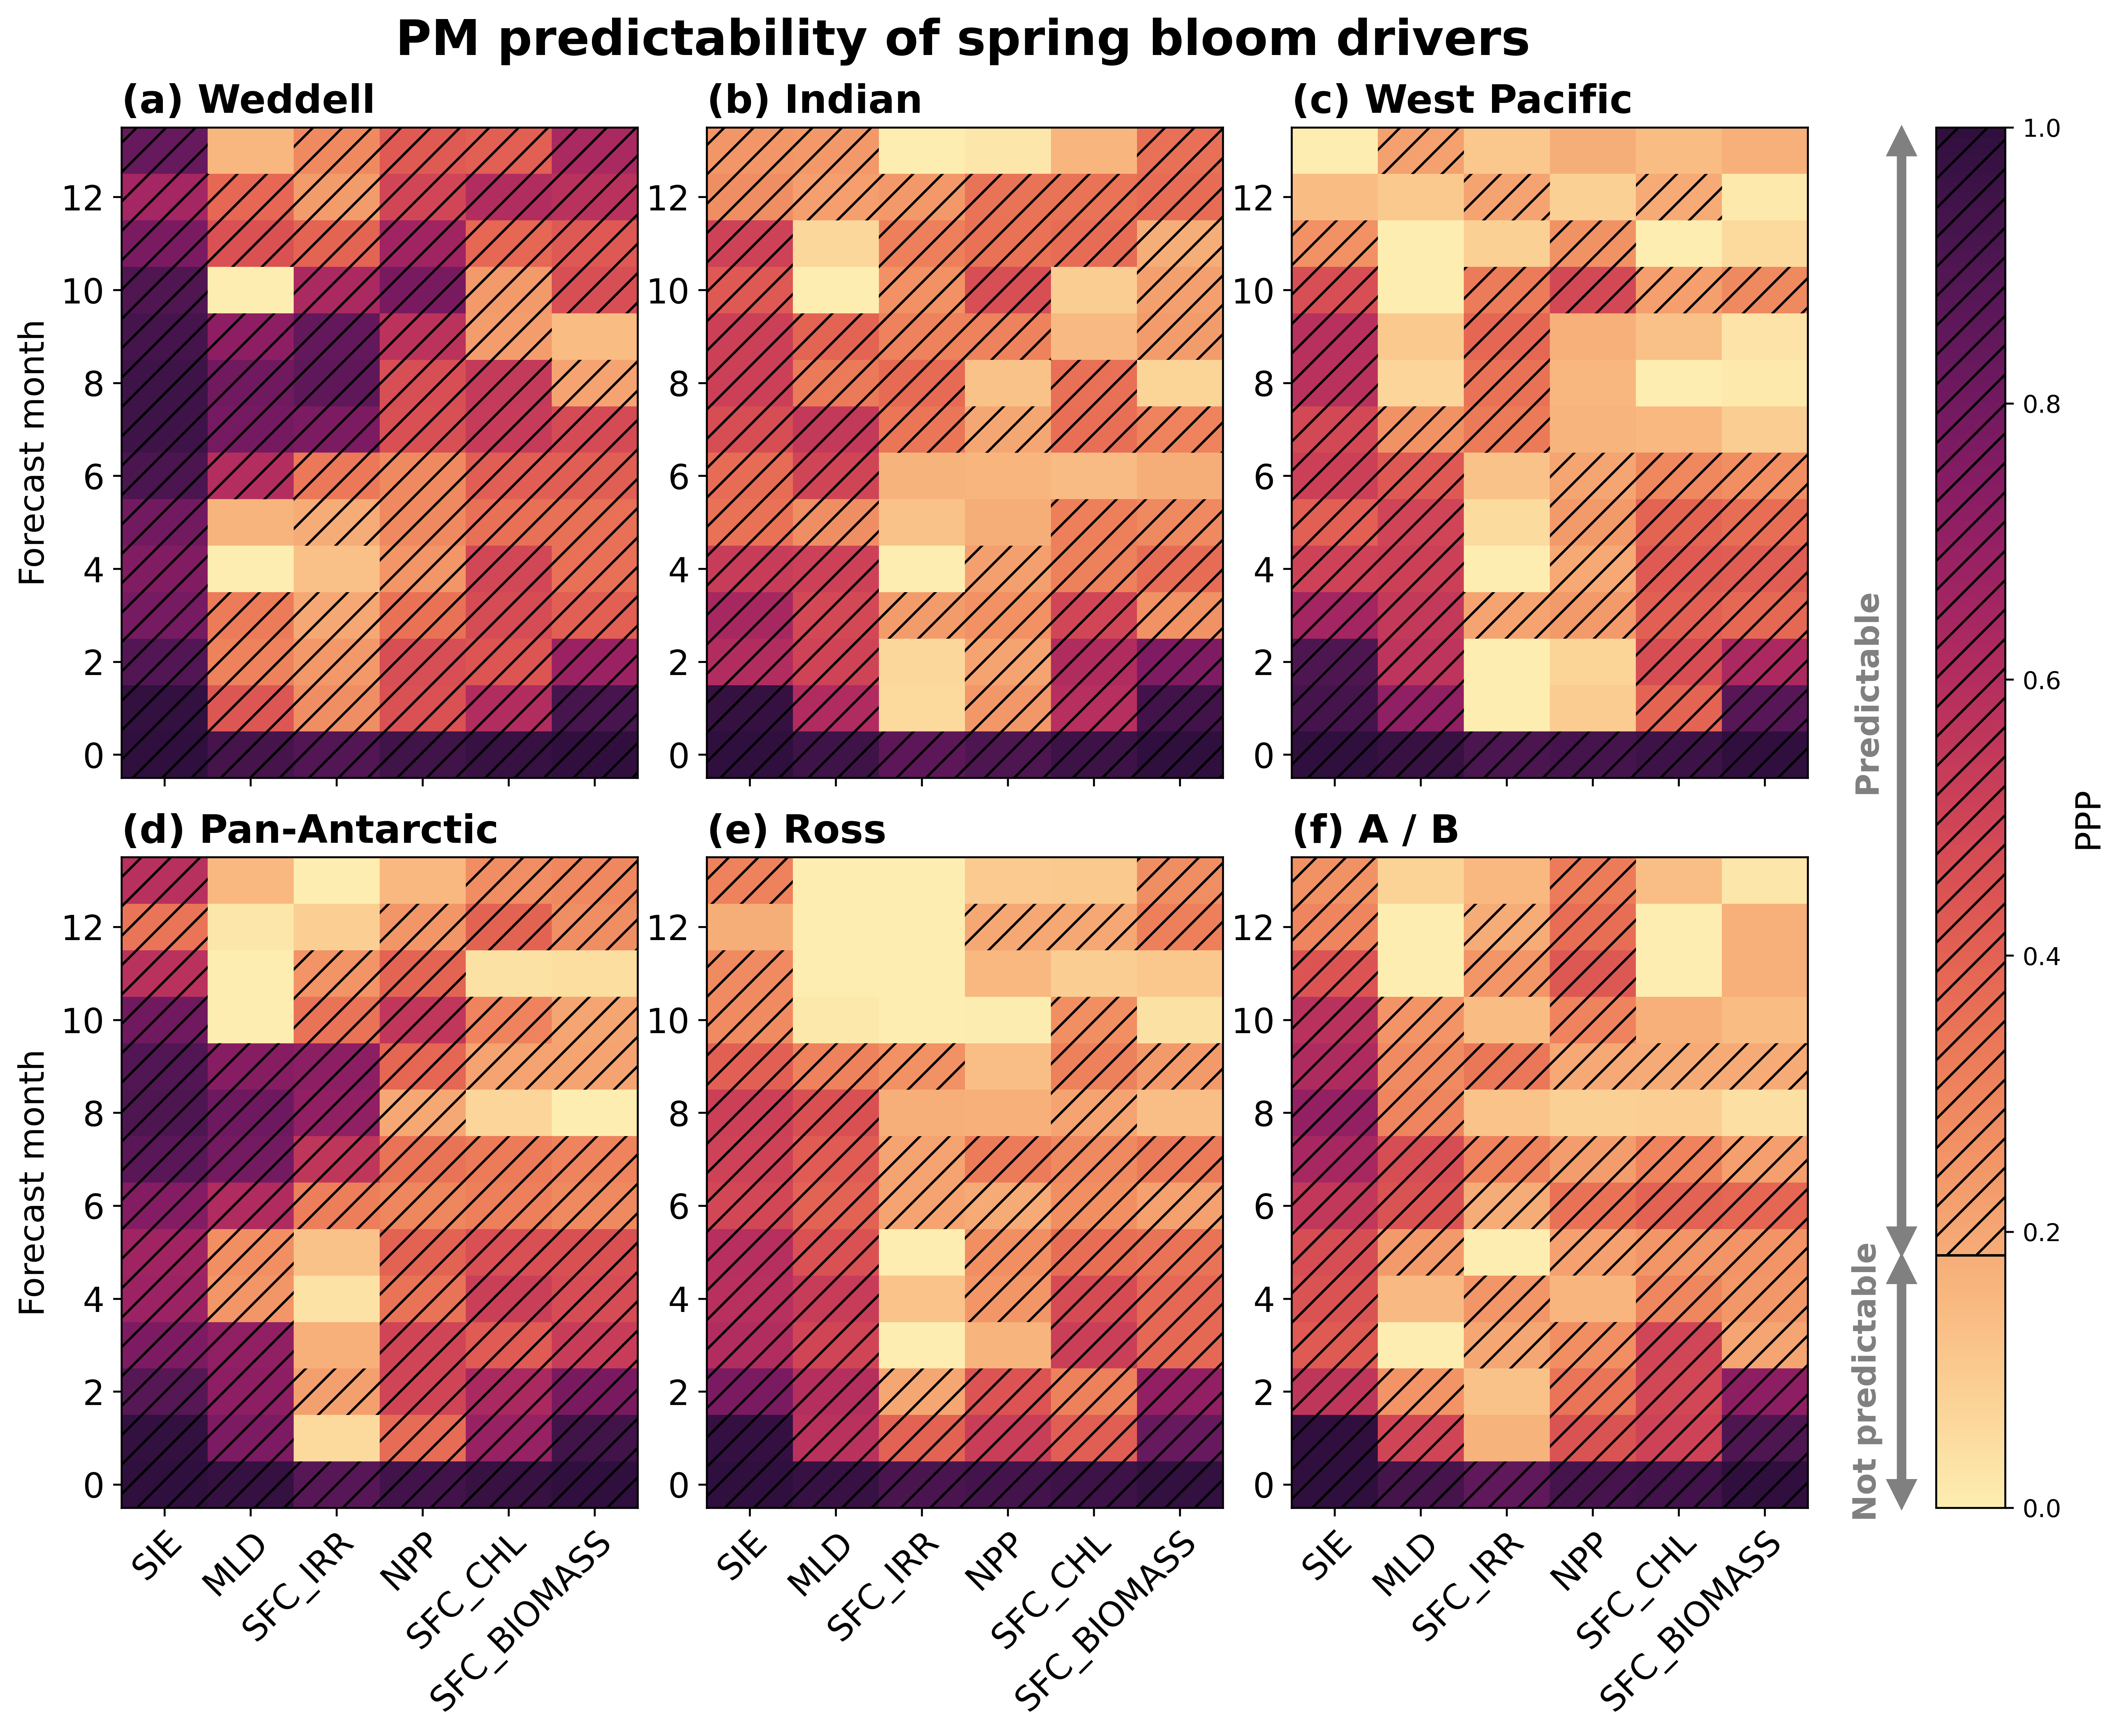

In [20]:
variables = ['sie', 'mld', 'sfc_irr', 'npp', 'sfc_chl', 'sfc_biomass']
ppp_var_heatmap(variables, 'all', num_months=14, figsize=(13,10), vmin=0, threshold=0.183, hatch='//');

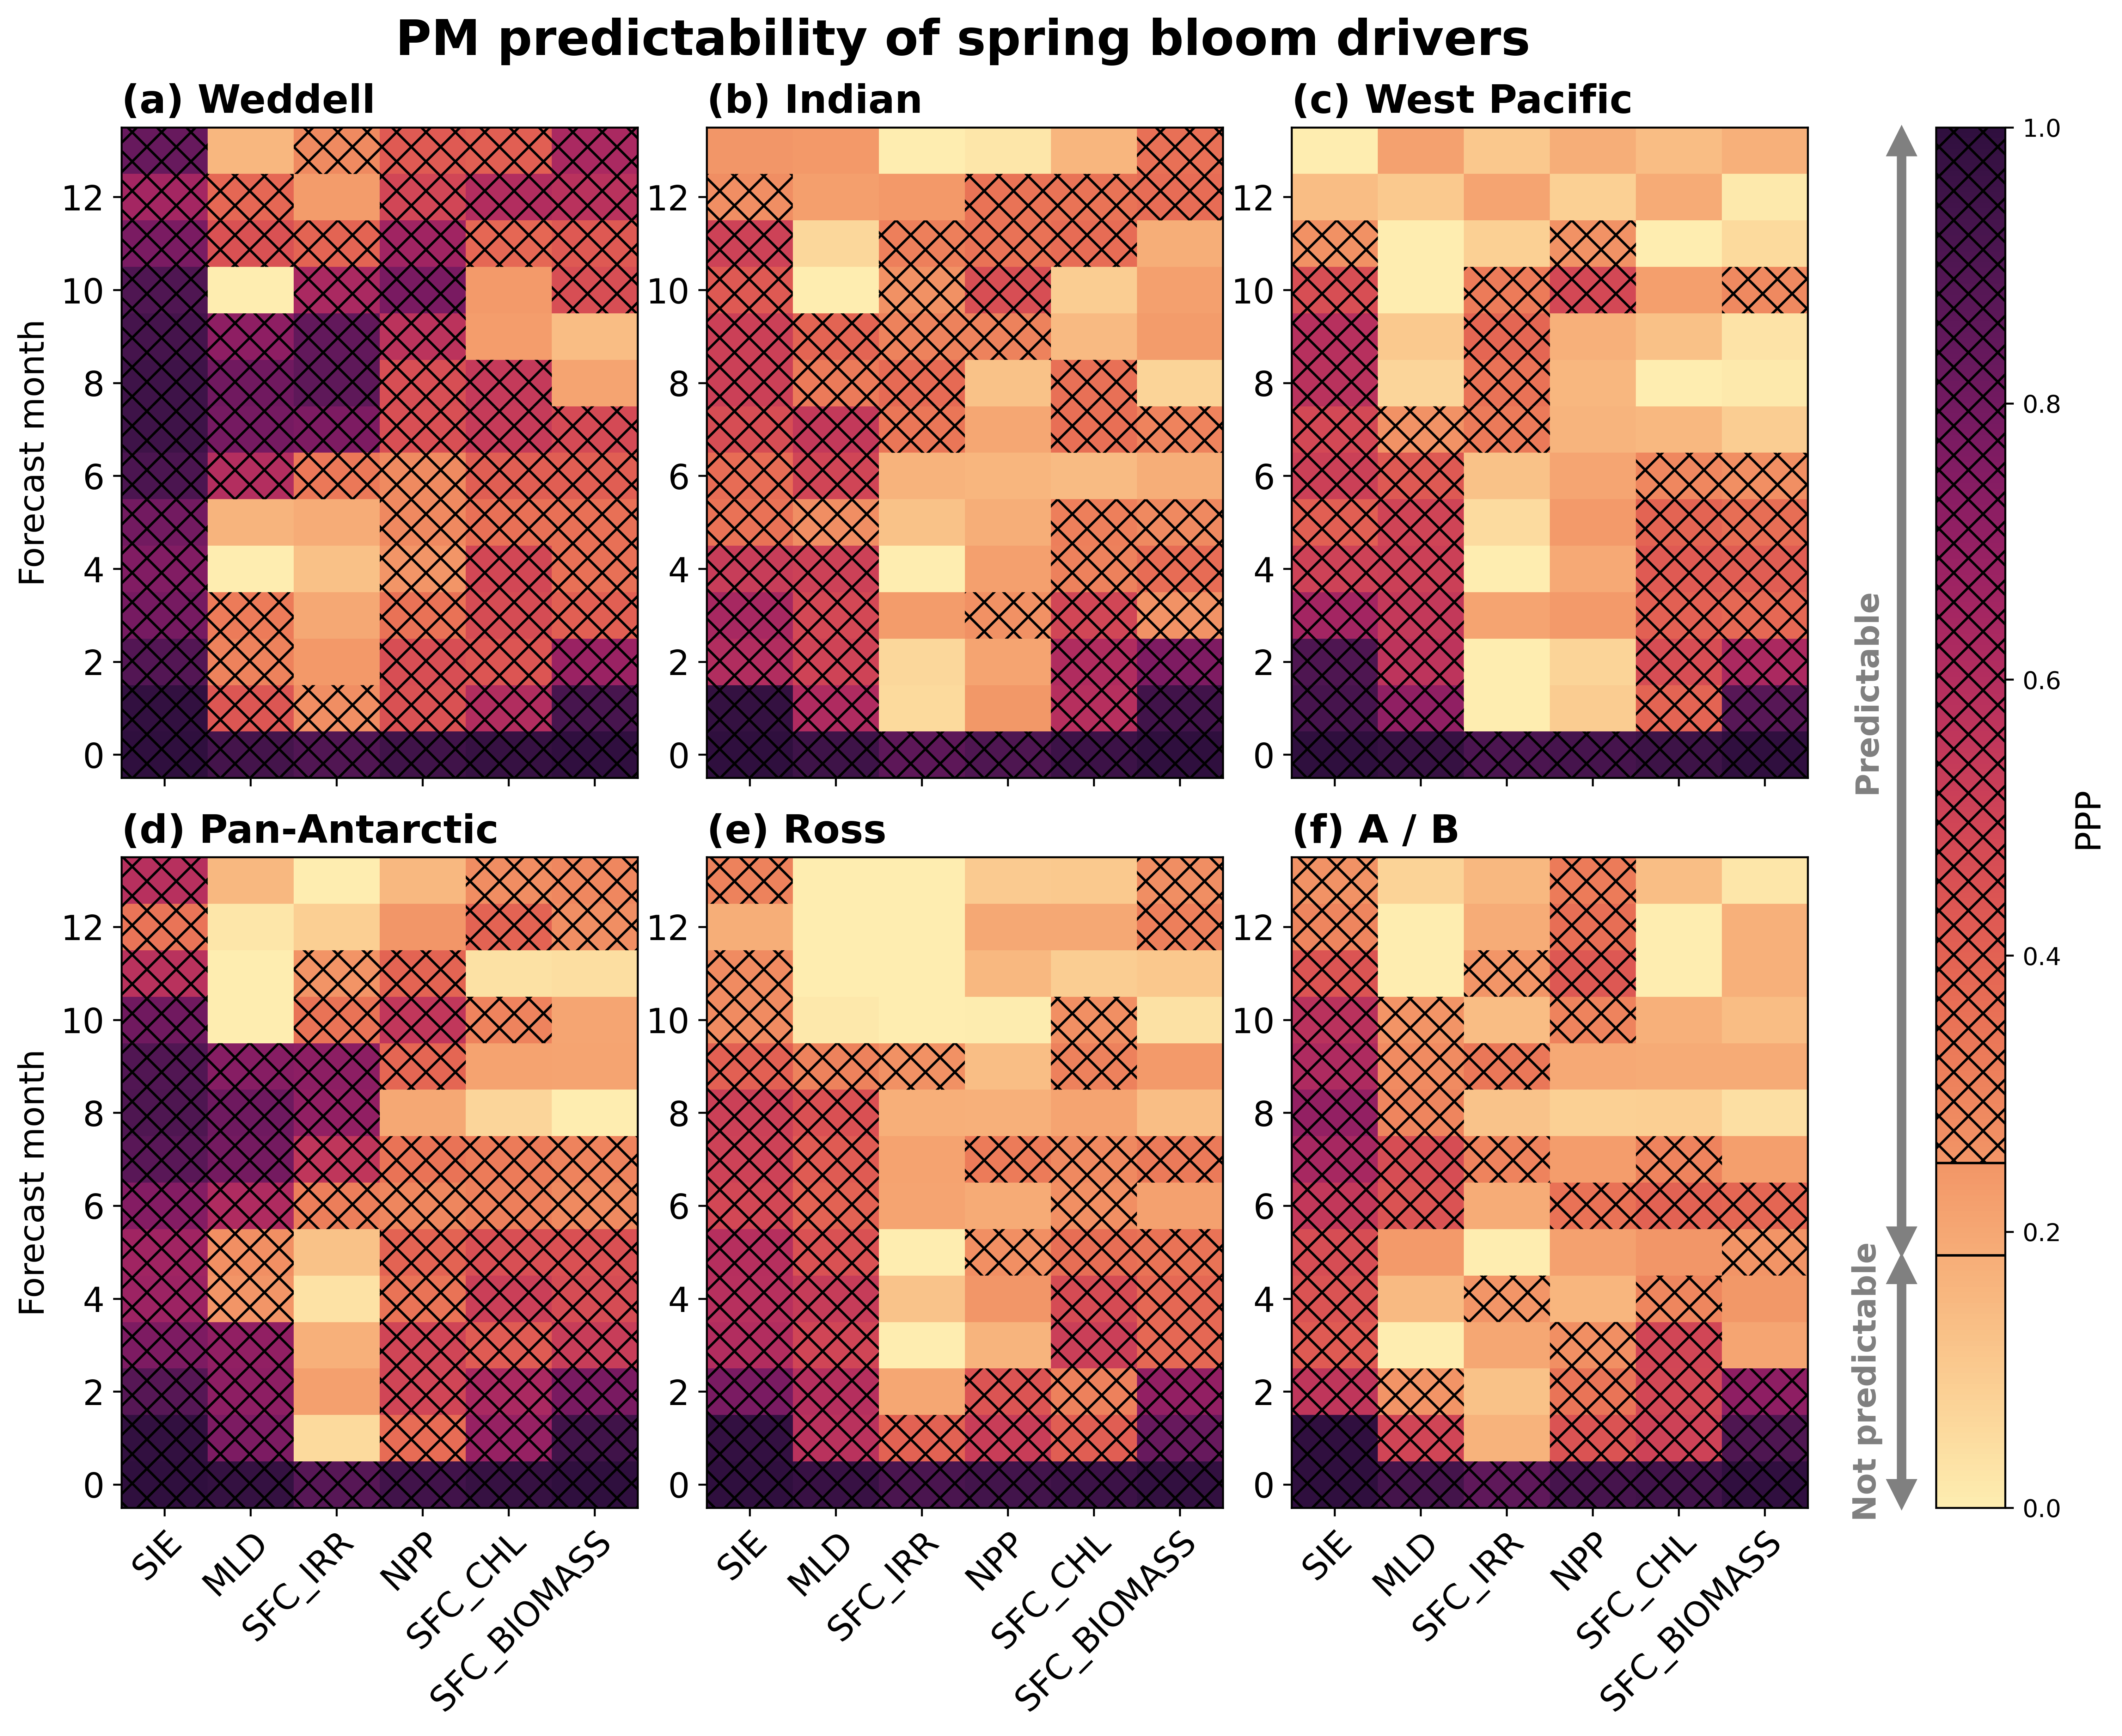

In [21]:
variables = ['sie', 'mld', 'sfc_irr', 'npp', 'sfc_chl', 'sfc_biomass']
ppp_var_heatmap(variables, 'all', num_months=14, figsize=(13,10), vmin=0, threshold=0.25, hatch='xx');

## Cross Correlation

In [14]:
## predictor --> the field doing the predicting (e.g., SIE or SFC_IRR)
## predictand --> the field being predicted (e.g., NPP)
def compute_lagged_xcorr(predictor, predictand, maxlag):
    ## convert DataArray to NumPy array
    predictor = predictor.values
    predictand = predictand.values
    
    assert predictor.size == predictand.size, 'predictor and predictand have different lengths'
    N = predictor.size
    
    ## rows are different init months, cols are different lags
    r_matrix = np.zeros((abs(maxlag)+1, 12))
    p_matrix = np.zeros((abs(maxlag)+1, 12))

    init_matrix = np.zeros((abs(maxlag)+1, 12))
    lag_matrix = np.zeros((abs(maxlag)+1, 12))
    
    lag_values = np.arange(maxlag, 1)
    for (it,init) in enumerate(range(0,12)):
        for (ig,lag) in enumerate(lag_values):   
            trim = 12*((abs(lag)-1)//12+1)
            init_matrix[ig][it] = init
            lag_matrix[ig][it] = lag
            
            if lag == 0:
                tmp_predictand = predictand[init:N:12]
                tmp_predictor = predictor[init:N:12]
                
            else:
                tmp_predictand = predictand[init+trim:N:12]
                tmp_predictor = predictor[init+trim+lag:N-trim+init:12]
            
            r_matrix[ig][it], p_matrix[ig][it] = stats.pearsonr(tmp_predictand, tmp_predictor)
            
    return r_matrix, p_matrix, init_matrix, lag_matrix

##############

def plot_regional_lagged_xcorr(predictor, predictand, maxlag=-13, threshold=0.30, threshold_arr=False, hatch='...', figsize=(12,8), labelfontsize=12, titlefontsize=14):
    plt.rcParams.update({'mathtext.default':'regular'})
    reg_names, var_abbrv_names, abbrv_month_names, month_letters, var_su_names = get_plotting_labels()
    region_list = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

    fig,ax = plt.subplots(2, 3, figsize=figsize)
    
    subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    
    for (ireg,reg) in enumerate(region_list):  
        ts_predictor = open_metric(predictor, 'so', 'anom')[reg]
        ts_predictand = open_metric(predictand, 'so', 'anom')[reg]

        r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)
    
        ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
        numlags = r.shape[0]
        r_transformed = np.empty(shape=r.shape)
        p_transformed = np.empty(shape=p.shape)
        for i in range(numlags):
            r_transformed[numlags-i-1] = r[i]
            p_transformed[numlags-i-1] = p[i]
        r = r_transformed
        p = p_transformed
        
        im = ax[int(ireg/3),ireg%3].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cmo.balance, edgecolor='gray', linewidth=0.01)
        
        if hatch:
            if threshold_arr:
                masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold[ireg], 0, 1))
                masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)
            else:
                masked = np.ma.masked_array(r, mask=np.where(abs(r) > threshold, 0, 1))
                masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)
        
        ax[int(ireg/3),ireg%3].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
        ax[int(ireg/3),ireg%3].set_yticklabels(np.arange(0,-maxlag+1)[::4], fontsize=labelfontsize)
        ax[int(ireg/3),ireg%3].set_xticks((np.arange(r.shape[1]) + 0.5))
        ax[int(ireg/3),ireg%3].set_xticklabels(month_letters, fontsize=labelfontsize)
        ax[int(ireg/3),ireg%3].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', loc='left', fontsize=titlefontsize)
        
        if ireg%3 == 0:
            ax[int(ireg/3),ireg%3].set_ylabel('Lead (month)', fontsize=labelfontsize)   

    fig.suptitle(r'correlation ( '+var_su_names[predictand]+'$_{target\:month}$, '+var_su_names[predictor]+'$_{lead\:month}$ )', ha='center', x=0.45, fontweight='bold', fontsize=titlefontsize+4)
    fig.tight_layout()
    
    cb = fig.colorbar(im, ax=ax.ravel().tolist())
    cb.set_label('Correlation coefficient', fontsize=labelfontsize)
    
#     if hatch:
#         cb.ax.plot([-1,1], [threshold,threshold], color='k')
#         cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
#         cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
#         cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

### SIE predicting NPP

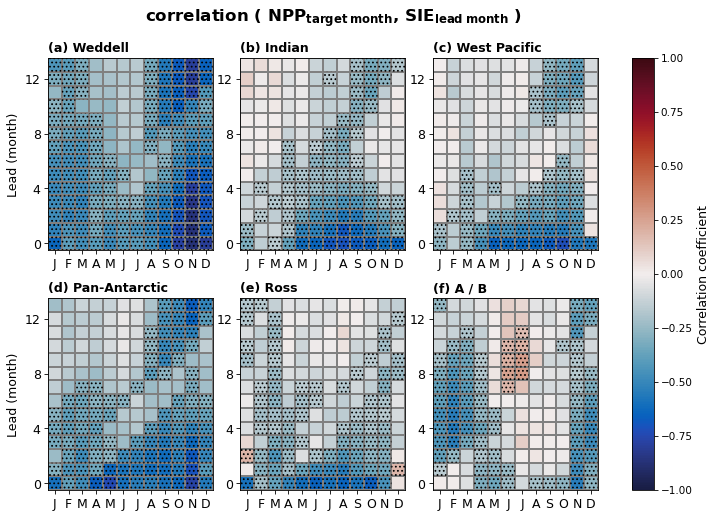

In [15]:
predictor = 'sie'
predictand = 'npp'
sie_pred_npp_rthresh = np.array([0.28028028, 0.15115115, 0.18318318, 0.24524525, 0.15115115, 0.14614615])
plot_regional_lagged_xcorr(predictor, predictand, threshold=sie_pred_npp_rthresh, threshold_arr=True, figsize=(10,7), labelfontsize=12, titlefontsize=12);

### SFC_IRR predicting NPP

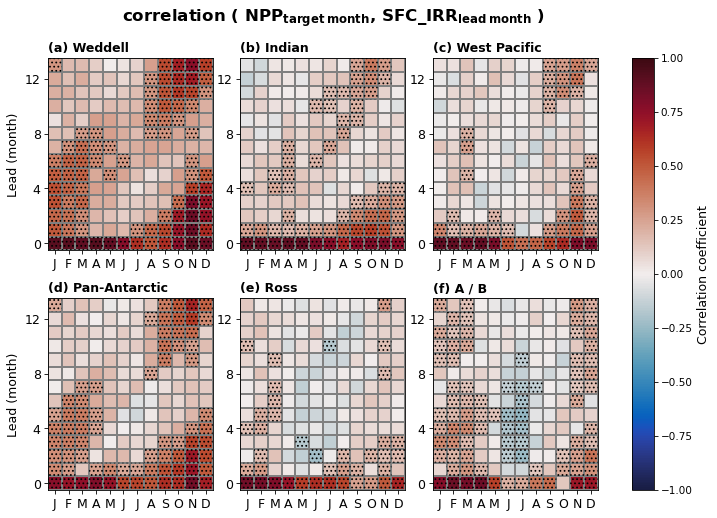

In [16]:
predictor = 'sfc_irr'
predictand = 'npp'
irr_pred_npp_rthresh = np.array([0.26926927, 0.14814815, 0.15615616, 0.22522523, 0.14914915, 0.12912913])
plot_regional_lagged_xcorr(predictor, predictand, threshold=irr_pred_npp_rthresh, threshold_arr=True, figsize=(10,7), labelfontsize=12, titlefontsize=12);

### SFC_FED predicting NPP

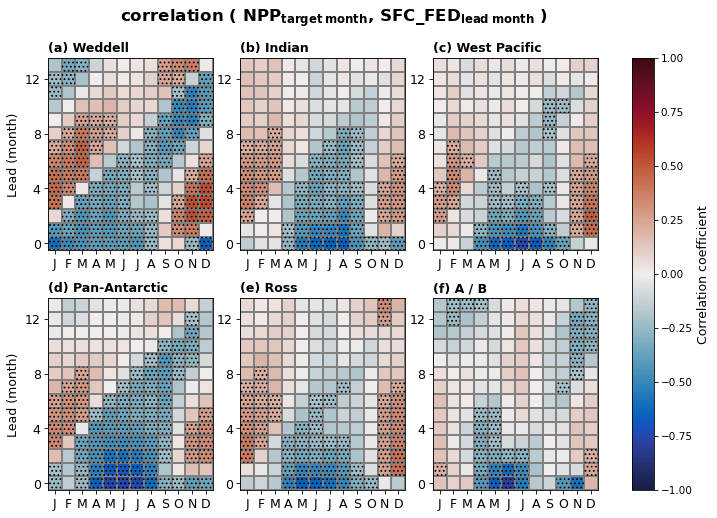

In [17]:
predictor = 'sfc_fed'
predictand = 'npp'
# irr_pred_npp_rthresh = np.array([0.26926927, 0.14814815, 0.15615616, 0.22522523, 0.14914915, 0.12912913])
plot_regional_lagged_xcorr(predictor, predictand, threshold=0.2, threshold_arr=False, figsize=(10,7), labelfontsize=12, titlefontsize=12);

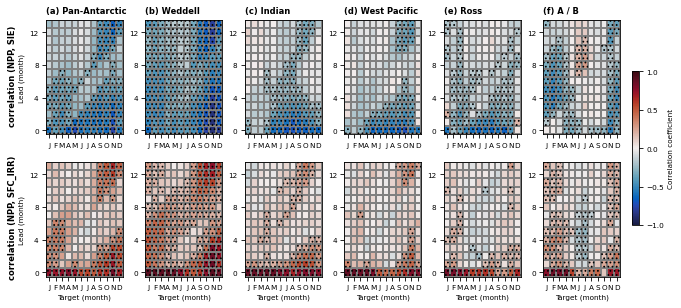

In [18]:
# predictor
# predictand
maxlag=-13
sie_pred_npp_rthresh = np.array([0.28028028, 0.15115115, 0.18318318, 0.24524525, 0.15115115, 0.14614615])
irr_pred_npp_rthresh = np.array([0.26926927, 0.14814815, 0.15615616, 0.22522523, 0.14914915, 0.12912913])
hatch='...'
figsize=(9,4)
labelfontsize=7
titlefontsize=8


plt.rcParams.update({'mathtext.default':'regular'})

reg_names, var_abbrv_names, abbrv_month_names, month_letters, var_su_names = get_plotting_labels()
region_list = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']

fig,ax = plt.subplots(2, 6, figsize=figsize, constrained_layout=True)

subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

for (ireg,reg) in enumerate(region_list):  
    ts_predictor = open_metric('SIE', 'so', 'anom')[reg]
    ts_predictand = open_metric('NPP', 'so', 'anom')[reg]

    r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)

    ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
    numlags = r.shape[0]
    r_transformed = np.empty(shape=r.shape)
    p_transformed = np.empty(shape=p.shape)
    for i in range(numlags):
        r_transformed[numlags-i-1] = r[i]
        p_transformed[numlags-i-1] = p[i]
    r = r_transformed
    p = p_transformed
    
#     print(r)
#     print()

    im = ax[0,ireg].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cmo.balance, edgecolor='gray', linewidth=0.01)

    masked = np.ma.masked_array(r, mask=np.where(abs(r) > sie_pred_npp_rthresh[ireg], 0, 1))
    masked_im = ax[0,ireg].pcolor(masked, hatch=hatch, alpha=0)

    ax[0,ireg].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
    ax[0,ireg].set_yticklabels(np.arange(0,-maxlag+1)[::4], fontsize=labelfontsize)
    ax[0,ireg].set_xticks((np.arange(r.shape[1]) + 0.5))
    ax[0,ireg].set_xticklabels(month_letters, fontsize=labelfontsize)
    ax[0,ireg].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', loc='left', fontsize=titlefontsize)

    if ireg == 0:
        ax[0,ireg].set_ylabel('Lead (month)', fontsize=labelfontsize)
        ax[0,ireg].text(-5.3, -maxlag/2+0.75, 'correlation (NPP, SIE)', clip_on=False, rotation='vertical', ha='center', va='center', fontsize=titlefontsize, fontweight='bold')

for (ireg,reg) in enumerate(region_list):  
    ts_predictor = open_metric('SFC_IRR', 'so', 'anom')[reg]
    ts_predictand = open_metric('NPP', 'so', 'anom')[reg]

    r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)

    ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
    numlags = r.shape[0]
    r_transformed = np.empty(shape=r.shape)
    p_transformed = np.empty(shape=p.shape)
    for i in range(numlags):
        r_transformed[numlags-i-1] = r[i]
        p_transformed[numlags-i-1] = p[i]
    r = r_transformed
    p = p_transformed

    im = ax[1,ireg].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cmo.balance, edgecolor='gray', linewidth=0.01)

    masked = np.ma.masked_array(r, mask=np.where(abs(r) > irr_pred_npp_rthresh[ireg], 0, 1))
    masked_im = ax[1,ireg].pcolor(masked, hatch=hatch, alpha=0)

    ax[1,ireg].set_xlabel('Target (month)', fontsize=labelfontsize)
    ax[1,ireg].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
    ax[1,ireg].set_yticklabels(np.arange(0,-maxlag+1)[::4], fontsize=labelfontsize)
    ax[1,ireg].set_xticks((np.arange(r.shape[1]) + 0.5))
    ax[1,ireg].set_xticklabels(month_letters, fontsize=labelfontsize)
#     ax[1,ireg].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', loc='left', fontsize=titlefontsize)

    if ireg == 0:
        ax[1,ireg].set_ylabel('Lead (month)', fontsize=labelfontsize)
        ax[1,ireg].text(-5.3, -maxlag/2+0.75, 'correlation (NPP, SFC_IRR)', clip_on=False, rotation='vertical', ha='center', va='center', fontsize=titlefontsize, fontweight='bold')
        
# fig.suptitle(r'correlation ( '+var_su_names[predictand]+'$_{target\:month}$, '+var_su_names[predictor]+'$_{lead\:month}$ )', ha='center', x=0.45, fontweight='bold', fontsize=titlefontsize+4)
# fig.tight_layout()

cb = fig.colorbar(im, ax=ax.ravel().tolist(), ticks=[-1,-0.5,0,0.5,1], shrink=0.6, pad=0.02)
cb.set_label('Correlation coefficient', fontsize=labelfontsize)
cb.ax.tick_params(labelsize=labelfontsize)

---

In [43]:
predictor
predictand
maxlag=-13
sie_pred_npp_rthresh = np.array([0.28028028, 0.15115115, 0.18318318, 0.24524525, 0.15115115, 0.14614615])
irr_pred_npp_rthresh = np.array([0.26926927, 0.14814815, 0.15615616, 0.22522523, 0.14914915, 0.12912913])
hatch='...'
figsize=(6,12)
labelfontsize=8
titlefontsize=10


plt.rcParams.update({'mathtext.default':'regular'})

reg_names, var_abbrv_names, abbrv_month_names, month_letters, var_su_names = get_plotting_labels()
region_list = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']

fig,ax = plt.subplots(6, 2, figsize=figsize)

subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

for (ireg,reg) in enumerate(region_list):  
    ts_predictor = open_metric('SIE', 'so', 'anom')[reg]
    ts_predictand = open_metric('NPP', 'so', 'anom')[reg]

    r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)

    ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
    numlags = r.shape[0]
    r_transformed = np.empty(shape=r.shape)
    p_transformed = np.empty(shape=p.shape)
    for i in range(numlags):
        r_transformed[numlags-i-1] = r[i]
        p_transformed[numlags-i-1] = p[i]
    r = r_transformed
    p = p_transformed

    im = ax[ireg,0].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cmo.balance, edgecolor='gray', linewidth=0.01)

    masked = np.ma.masked_array(r, mask=np.where(abs(r) > sie_pred_npp_rthresh[ireg], 0, 1))
    masked_im = ax[ireg,0].pcolor(masked, hatch=hatch, alpha=0)

    ax[ireg,0].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
    ax[ireg,0].set_yticklabels(np.arange(0,-maxlag+1)[::4], fontsize=labelfontsize)
    ax[ireg,0].set_xticks((np.arange(r.shape[1]) + 0.5))
    ax[ireg,0].set_xticklabels(month_letters, fontsize=labelfontsize)
    ax[ireg,0].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', loc='left', fontsize=titlefontsize)

    ax[ireg,0].set_ylabel('Lead (month)', fontsize=labelfontsize)
    
    if ireg == 5:
        ax[ireg,0].set_xlabel('Target (month)', fontsize=labelfontsize)

for (ireg,reg) in enumerate(region_list):  
    ts_predictor = open_metric('SFC_IRR', 'so', 'anom')[reg]
    ts_predictand = open_metric('NPP', 'so', 'anom')[reg]

    r, p, inits, lags = compute_lagged_xcorr(ts_predictor, ts_predictand, maxlag=maxlag)

    ## transform r so that lead=0 is the bottom row and lead=maxlag is top row
    numlags = r.shape[0]
    r_transformed = np.empty(shape=r.shape)
    p_transformed = np.empty(shape=p.shape)
    for i in range(numlags):
        r_transformed[numlags-i-1] = r[i]
        p_transformed[numlags-i-1] = p[i]
    r = r_transformed
    p = p_transformed

    im = ax[ireg,1].pcolormesh(r, vmin=-1.0, vmax=1.0, cmap=cmo.balance, edgecolor='gray', linewidth=0.01)

    masked = np.ma.masked_array(r, mask=np.where(abs(r) > irr_pred_npp_rthresh[ireg], 0, 1))
    masked_im = ax[ireg,1].pcolor(masked, hatch=hatch, alpha=0)

    ax[ireg,1].set_yticks((np.arange(r.shape[0]) + 0.5)[::4])
    ax[ireg,1].set_yticklabels(np.arange(0,-maxlag+1)[::4], fontsize=labelfontsize)
    ax[ireg,1].set_xticks((np.arange(r.shape[1]) + 0.5))
    ax[ireg,1].set_xticklabels(month_letters, fontsize=labelfontsize)
#     ax[ireg,1].set_title(subplots[ireg]+' '+reg_names[reg], fontweight='bold', loc='left', fontsize=titlefontsize)

    if ireg == 5:
        ax[ireg,1].set_xlabel('Target (month)', fontsize=labelfontsize)
        
        
# fig.suptitle(r'correlation ( '+var_su_names[predictand]+'$_{target\:month}$, '+var_su_names[predictor]+'$_{lead\:month}$ )', ha='center', x=0.45, fontweight='bold', fontsize=titlefontsize+4)
fig.tight_layout()

# cb = fig.colorbar(im, ax=ax.ravel().tolist())
# cb.set_label('Correlation coefficient', fontsize=labelfontsize)

<Figure size 1800x3600 with 12 Axes>